Credit Ratings

---
author: Alex Kim
date: September 25, 2024
embed-resources: true
---

## Introduction

Credit rating is an evaluation of the credit risk of a potential debtor, which could be an individual, organization, or business. Credit rating determines an individual creditworthiness, which can affect one's ability to obtain credit or loans. Financial institutions like banks often relied on external credit agencies to provide credit ratings of customers. However, in terms of expense and cost, this isn't the most ideal approach as it costs additional bank money. In effort to reduce the expenses, our main objective is to create a credit rating model that makes use of the customers' credit rating based on the credit ratings we have acquired along with income and demographic data we gathered from customers. In this lab report, we will be reverse engineering the customers' credit rating by predicting an individual's credit score through the use of regression algorithms and techniques. We can develop a predicive model that allows the bank to evaluate future customers' creditworthiness without the need of external credit agencies by analyzing past credit scores and demographic information like age, income, and education level. 

## Methods

In [355]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.metrics import accuracy_score, root_mean_squared_error

To develop the predictive regression model that predicts an individual's credit rating, we will be using a combined modification of a simulated credit data from "An Introduction to Statistical Learning" and credit data from ISLP credit data available on GitHub. According to the ISLP Documentation: Credit Card Balance Data, the data was originally collected and used in a way to predict the balance on credit cards. In order to make this data suitable and appropriate for predicting individual's credit rating, some variables from the original data has been removed.

### Data Dictionary
The train and test datasets consists of various information of banking customers.
#### Response
* **Rating** [float64]: credit rating, specifically the credit score of an individual consumer

#### Feature
* **Income** [float64]: yearly income in $1000s

* **Age** [int64]: age

* **Education** [int64]: years of education completed

* **Gender** [object]: gender

* **Student** [object]: a Yes / No variable with Yes indicating an individual is a student

* **Married** [object]: a Yes / No variable with Yes indicating an individual is married

* **Ethnicity** [object]: ethnicity

### Data

In [356]:
# load data
credit_train = pd.read_csv("https://cs307.org/lab-02/data/credit-train.csv")
credit_test = pd.read_csv("https://cs307.org/lab-02/data/credit-test.csv")
credit_train

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
0,257.0,44.473,81.0,16.0,Female,No,No,NaN
1,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
2,388.0,16.479,26.0,16.0,Male,NaN,No,NaN
3,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
4,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian
...,...,...,...,...,...,...,...,...
251,268.0,26.370,78.0,11.0,Male,No,Yes,Asian
252,433.0,26.427,50.0,15.0,Female,Yes,Yes,Asian
253,259.0,12.031,58.0,18.0,Female,NaN,Yes,Caucasian
254,335.0,80.861,29.0,15.0,Female,No,Yes,Asian


In [357]:
#Summary Statistics
# # of Sample & Features
credit_train.shape

(256, 8)

There are 256 samples and 7 features in the train dataset.

In [358]:
# Rating (Target) Statistics - Mean & Standard Deviation
rating_mean = credit_train['Rating'].mean()
rating_std = credit_train['Rating'].std()
print(f"The mean of Rating is {rating_mean}, and the Standard Deviation of Rating is {rating_std}")

The mean of Rating is 347.609375, and the Standard Deviation of Rating is 148.8931046679028


The result above provides the mean and standard deviation of Rating.

In [359]:
# Rating Statistics Based on Student Status - Count, Mean, & Standard Deviation
stu_yes = credit_train[credit_train['Student']=='Yes']
stu_no = credit_train[credit_train['Student']=='No']
mean_stu_yes = stu_yes.Rating.mean()
std_stu_yes = stu_yes.Rating.std()
mean_stu_no = stu_no.Rating.mean()
std_stu_no = stu_no.Rating.std()
count_stu = credit_train['Student'].agg(["value_counts"]).rename(columns={"value_counts": "count"})
print(count_stu)
print(f'Student(Yes) Mean: {mean_stu_yes}, Student(Yes) Standard Deviation: {std_stu_yes}')
print(f'Not Student(No) Mean: {mean_stu_no}, Not Student(No) Standard Deviation: {std_stu_no}')

         count
Student       
No         213
Yes         19
Student(Yes) Mean: 338.4736842105263, Student(Yes) Standard Deviation: 149.1644761183859
Not Student(No) Mean: 349.51173708920186, Not Student(No) Standard Deviation: 148.00352527445554


The result above provides the count of those who are and are not students through 'Yes' or 'No'. It also provides the mean and standard deviation of those who are student and those who are not students.

In [360]:
# Rating Statistics Based on Marriage Status - Count, Mean, & Standard Deviation
mar_yes = credit_train[credit_train['Married']=='Yes']
mar_no = credit_train[credit_train['Married']=='No']
mean_mar_yes = mar_yes.Rating.mean()
std_mar_yes = mar_yes.Rating.std()
mean_mar_no = mar_no.Rating.mean()
std_mar_no = mar_no.Rating.std()
count_mar = credit_train['Married'].agg(["value_counts"]).rename(columns={"value_counts": "count"})
print(count_mar)
print(f'Married(Yes) Mean: {mean_mar_yes}, Married(Yes) Standard Deviation: {std_mar_yes}')
print(f'Not Married(No) Mean: {mean_mar_no}, Not Married(No) Standard Deviation: {std_mar_no}')

         count
Married       
Yes        158
No          98
Married(Yes) Mean: 358.90506329113924, Married(Yes) Standard Deviation: 157.7979352901777
Not Married(No) Mean: 329.3979591836735, Not Married(No) Standard Deviation: 132.03964882478107


The result above provides the count of those who are and are not mattied through 'Yes' or 'No'. It also provides the mean and standard deviation of those who are married and those who are not married.

In [361]:
# Correlation with Target vs Age
credit_train[['Age','Rating']].corr()

,Age,Rating
Age,1.000000,0.143032
Rating,0.143032,1.000000


The correlation between Age and Rating (target variable) is 0.143032, which reflects that there is a weak relationship between the two variables.

<Axes: xlabel='Age', ylabel='Rating'>

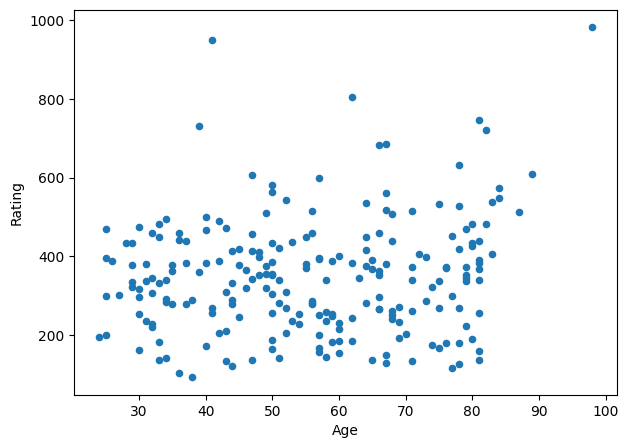

In [362]:
# Visualiation of Target vs Age Correlation
credit_train.plot.scatter(x='Age',y='Rating',marker='o',figsize=(7,5))

In [363]:
# Correlation with Target vs Income
credit_train[['Income','Rating']].corr()

,Income,Rating
Income,1.000000,0.770842
Rating,0.770842,1.000000


The correlation between Income and Rating (target variable) is 0.770842, which reflects that there is a some relationship present between the two variables. 

<Axes: xlabel='Income', ylabel='Rating'>

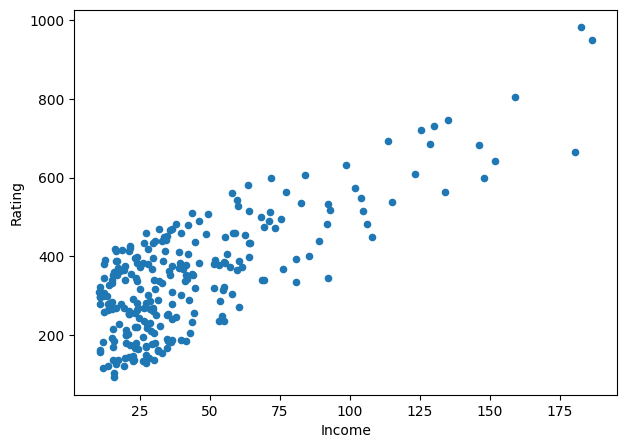

In [364]:
# Visualization of Target vs Income Correlation
credit_train.plot.scatter(x='Income',y='Rating',marker='o',figsize=(7,5))

The visualizations above displays the correlation of the Income and Age features with the target variable, which is Rating. Through the visualization we can further interpret the potential relationships present between the features, such as Income and Age, and the tagert variable, Rating. 

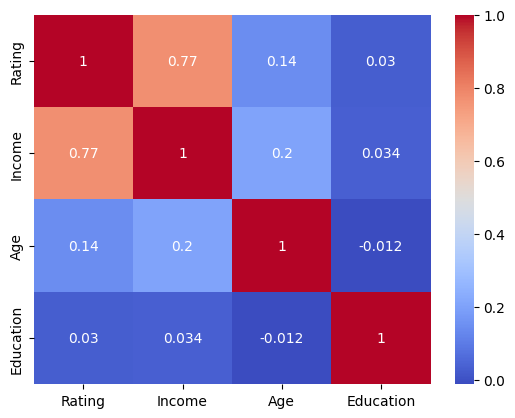

In [365]:
credit_num = credit_train[['Rating','Income','Age','Education']]
corr_matrix = credit_num.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

The heatmap above displays the correlation between the numerical variables (Income, Age, and Education) and the target numerial variable, Rating. This allows us to easily identify the strength of relationships between the (numerical) features and the target variable.

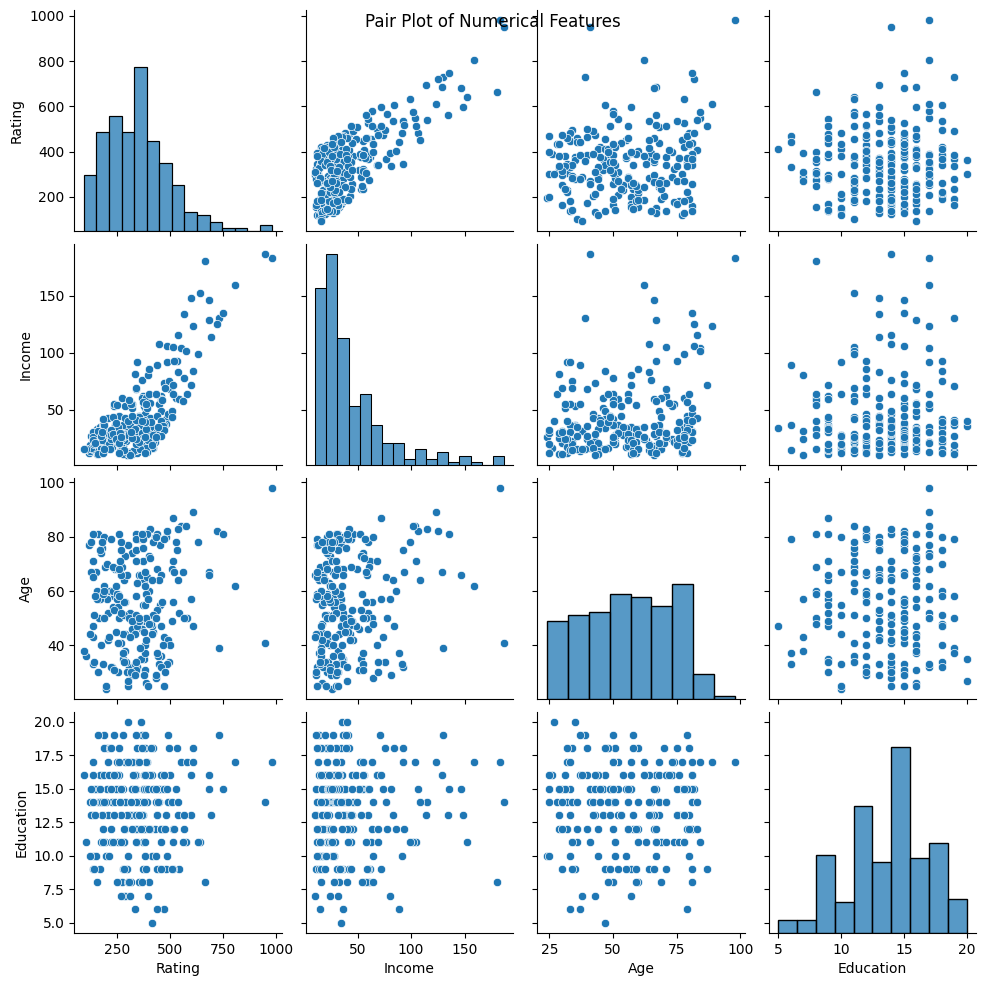

In [366]:
sns.pairplot(credit_num)
plt.suptitle('Pair Plot of Numerical Features') 
plt.show()

The pairplot above visually represents the relationships between numerical features and target variable, which is Rating, in the training dataset. This allows us to further explore any potential relationships between features themselves.

In [367]:
# Proportion Missing Data of Rating (Target)
missing = credit_train.isnull().sum() / credit_train.shape[0]
missing_val = pd.DataFrame({'Variables': credit_train.columns,
                           'Proportion Missing': missing})
print(missing_val)

           Variables  Proportion Missing
Rating        Rating            0.000000
Income        Income            0.000000
Age              Age            0.128906
Education  Education            0.097656
Gender        Gender            0.023438
Student      Student            0.093750
Married      Married            0.000000
Ethnicity  Ethnicity            0.097656


The result above shows the proportion of missing values or data across all features and variables in the train dataset.

The above results and visualizations provide insight into the training dataset. Notably, it shows that there is a pretty strong relationshp between Income and Rating (response variable). It also shows that features like Age, Ethnicity, education have high proportion of missing values in the training dataset.

### Models

In [368]:
# process data for ML
# create X and y for train
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

# create X and y for test
X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [369]:
# note numeric and categorical features
numeric_features = ['Income'] ##Education replaced into categorical_features, Age removed 
categorical_features = ['Gender','Student','Married', 'Education'] ##Ethnicity Removed 

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", KNeighborsRegressor()),
    ]
)

In [370]:
# define parameter grid
param_grid = {
    "regressor__n_neighbors": range(1, 51, 3),
    "regressor__metric": ["euclidean", "manhattan"],
}

In [371]:
# setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error')

In [372]:
# run grid search with cross-validation
mod = grid_search.fit(X_train, y_train)

To develop a model, the sklearn pipline with cross validation was utilized to predict credit ratings. The model also uses K-nearst neighbors (KNN) regresson where we tune a wide range of potential values for k. The pipline consists of several preprocessing steps for categorical and numerical variables in the dataset. Lastly, to minimize the RMSE and find the best hyperparameters for the model (which is the number of neighbors), a grid search with cross-validation is performed. 

## Results

In [373]:
# report model metrics
root_mean_squared_error(mod.predict(X_test), y_test)

np.float64(108.76336045226722)

The predictive regression model achieves a test RMSE of 108.7633.

## Discussion

The predictive regression model that predict credit ratings was developed using features like income, gender, ethnicity, age, education level, student status, and martial status. Conducting hyperparamter tuning of number or range of neighbors through grid search with cross validation, the best model was produced based off of the low root mean squared error (RMSE) value of 108.7633. Although the model may be provide good prediction of credit ratings, I still would not use this selected model for real-world practice. 

In the summary statistics portion, we discovered that several features or variables in the train dataset had some missing values present as shown in the missing value proportion results. To counter or "fill in" the missing values, the SimpleImputer class, which provides basic replacement approaches like mean and mode(most_frequent) for imputing missing values, was utilized in the scikit learn pipline. Although this may be good alternative approach, it can possibly introduce bias and limitation to the model, leading to inaccurate results. The simple data imputation method can often oversimplify trends or patterns. This can further lead the imputed features to bring about less meaningful and useful data values for the model. In the process of developing the model, I made the decision to remove some of the features that may introduce bias and arise ethical concerns. I removed Age because it had the highest missing proportion out of all features with 0.128906. This would mean that Age would contain relatively more missing values imputed through the SimpleImputer class, which could possibly introduce more bias. I then removed Ethnicity with the second highest missing proportion (0.097656). This was also done in effort to prevent ethical implications, which is why I considered Ethnicity to be not be so strongly correlated with credit rating.

Although feature like Ethnicity was removed to avoid ethical concerns in the model, other features such as gender, student, and married can raise ethical and legal issues. These variables can be described as demographic information, which can often be sensitive and be disadvantages. For instance, even if the model did not aim to discriminate, it could often discriminate against certain gender of people when it comes to determining creditworthiness. Similarly, student and martial status can be groups of people who are unfairly disadvantaged in terms of credit rating with other potential (social or economic) factors playing a role.

Whether the predictive model performs well or not, it doesn't seem appropriate to use the demographic features or information for predicting credit rating and creditworthiness. Just because we can use such features does not mean we should use them to predict credit rating. If this careful ethical consideration in machine learning isn't made, it could worsen existing biases or prejudice agaisnt certain group of people. In worst case scenario, such credit rating model can prolong systematic discrimination if it is used in real-world practice. 

### Conclusion

Overall, I would not use this model for predicting credit rating or creditworthiness in real-world scenarios. The model is consisted of features and variables that would most likely cause ethical and legal issues when used in practice. This model would need to be significantly refined and improved, possibly by using features that would not or less likely to raise ethical and legal concerns.